In [1]:
using CSV, DataFrames, PyPlot, ScikitLearn, Random
# support vector classifier
@sk_import svm : SVC
# K-folds cross validation
using ScikitLearn.CrossValidation: KFold
using IterTools
gb = DataFrames.groupby #had to do this for some weird reason

groupby (generic function with 2 methods)

## Classification of wine based on quality
**CHE 599: Introduction to Data Science     ||    Fall 2019 Term Project     ||    Siddharth Ganesh     ||**

The source of the data is taken from the UCI Machine Learning Repository. [link](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)

There are 2 CSV files, one for red and one for white wine. Each row of CSV represents measurements on a variation of Portugese wine. The 12 attributes available are:
* `fixed_acidity`
* `volatile_acidity`
* `citric_acid`
* `residual_sugar`
* `chlorides` 
* `free_so2`        
* `total_so2`       
* `density`         
* `pH`              
* `sulphates`       
* `alcohol`         
* `quality`      

## Aim

- To predict the ***quality*** of wine based on given attributes and to find the ***most relevant*** two attributes to best predict the quality.  

## The CSV file for white wine is read and the first 5 rows are displayed.

In [2]:
dfw = CSV.read("winequality-white.csv", copycols = true)
first(dfw, 5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2
,Float64,Float64,Float64,Float64,Float64,Float64
1,7.0,0.27,0.36,20.7,0.045,45.0
2,6.3,0.3,0.34,1.6,0.049,14.0
3,8.1,0.28,0.4,6.9,0.05,30.0
4,7.2,0.23,0.32,8.5,0.058,47.0
5,7.2,0.23,0.32,8.5,0.058,47.0


## Next, the CSV file for red wine is read and the first 5 rows are displayed.

In [3]:
dfr = CSV.read("winequality-red.csv", copycols = true)
first(dfr, 5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2
,Float64,Float64,Float64,Float64,Float64,Float64
1,7.4,0.7,0.0,1.9,0.076,11.0
2,7.8,0.88,0.0,2.6,0.098,25.0
3,7.8,0.76,0.04,2.3,0.092,15.0
4,11.2,0.28,0.56,1.9,0.075,17.0
5,7.4,0.7,0.0,1.9,0.076,11.0


## Now, both the data frames are combined.

> The data frames are combined since the colour of the wine is not considered as an attribute in this data analysis.

In [4]:
df_all = vcat(dfw,dfr)
size(df_all)

(6497, 12)

## The data frame is grouped based on the quality attribute.
> The different values in quality attribute and the total rows for each quality is determined.

In [95]:
quality_group = by(df_all, :quality, total=:quality=> length)
sort!(quality_group, :quality)
quality_group

,quality,total
,Int64,Int64
1,3,30
2,4,216
3,5,2138
4,6,2836
5,7,1079
6,8,193
7,9,5


> Based on this information we select the ***lowest two (3, 4)*** quality ratings and the ***highest two (8, 9)*** quality ratings and make a new data frame.
> This is done to spread the data so that they can be categorized more accurately later.

In [6]:
dfe = deepcopy(df_all)

#filtering the rows that have the quality values of interest
df_3 = filter(row -> row[:quality] == 3, dfe)
df_4 = filter(row -> row[:quality] == 4, dfe)
df_8 = filter(row -> row[:quality] == 8, dfe)
df_9 = filter(row -> row[:quality] == 9, dfe)

#combining low quality together and high quality together
df_low = vcat(df_3,df_4)
df_high = vcat(df_8,df_9)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2
,Float64,Float64,Float64,Float64,Float64,Float64
1,6.2,0.66,0.48,1.2,0.029,29.0
2,6.2,0.66,0.48,1.2,0.029,29.0
3,6.8,0.26,0.42,1.7,0.049,41.0
4,6.7,0.23,0.31,2.1,0.046,30.0
5,6.7,0.23,0.31,2.1,0.046,30.0
6,5.2,0.44,0.04,1.4,0.036,43.0
7,5.2,0.44,0.04,1.4,0.036,43.0
8,6.8,0.53,0.35,3.8,0.034,26.0
9,6.7,0.26,0.39,1.1,0.04,45.0


## Two new columns are added to the data frame, one for rating and one for class.
> Quality 3 & 4 are rated as ***Low Quality*** and quality 8 & 9 are rated as ***High Quality***. 
> 
> The low quality rows are assigned -1 class and high quality rows are assigned 1 class.

In [7]:
df_low[!, :rating] = vcat(["Low Quality" for i = 1:nrow(df_low)])
df_low[!, :class] = vcat([-1 for i = 1:nrow(df_low)])


df_high[!, :rating] = vcat(["High Quality" for i = 1:nrow(df_high)])
df_high[!, :class] = vcat([1 for i = 1:nrow(df_high)])

#finally, the data frames are combined to form one main data frame
df=vcat(df_low,df_high)
size(df)

(444, 14)

## The number of wines in each rating is seen.

In [8]:
by(df, :rating, total=:class=> length)

,rating,total
,String,Int64
1,Low Quality,246
2,High Quality,198


## Data Visualization

- A scatter plot of the data is visualized for pairs of the attributes.

- There are **11** attributes and **2** attributes per combination which makes a total of **66 combinations**. (nCr)

In [9]:
attributes = [:fixed_acidity, :volatile_acidity, :citric_acid, :residual_sugar, :chlorides, 
    :free_so2, :total_so2, :density, :pH, :sulphates, :alcohol, :quality]
a = DataFrame(x=[],y=[])
for i in subsets(attributes, 2)
    push!(a, i)
end

In [10]:
# for i in 1:size(a)[1]
#     @show ((a[!, 1][i]))
# end

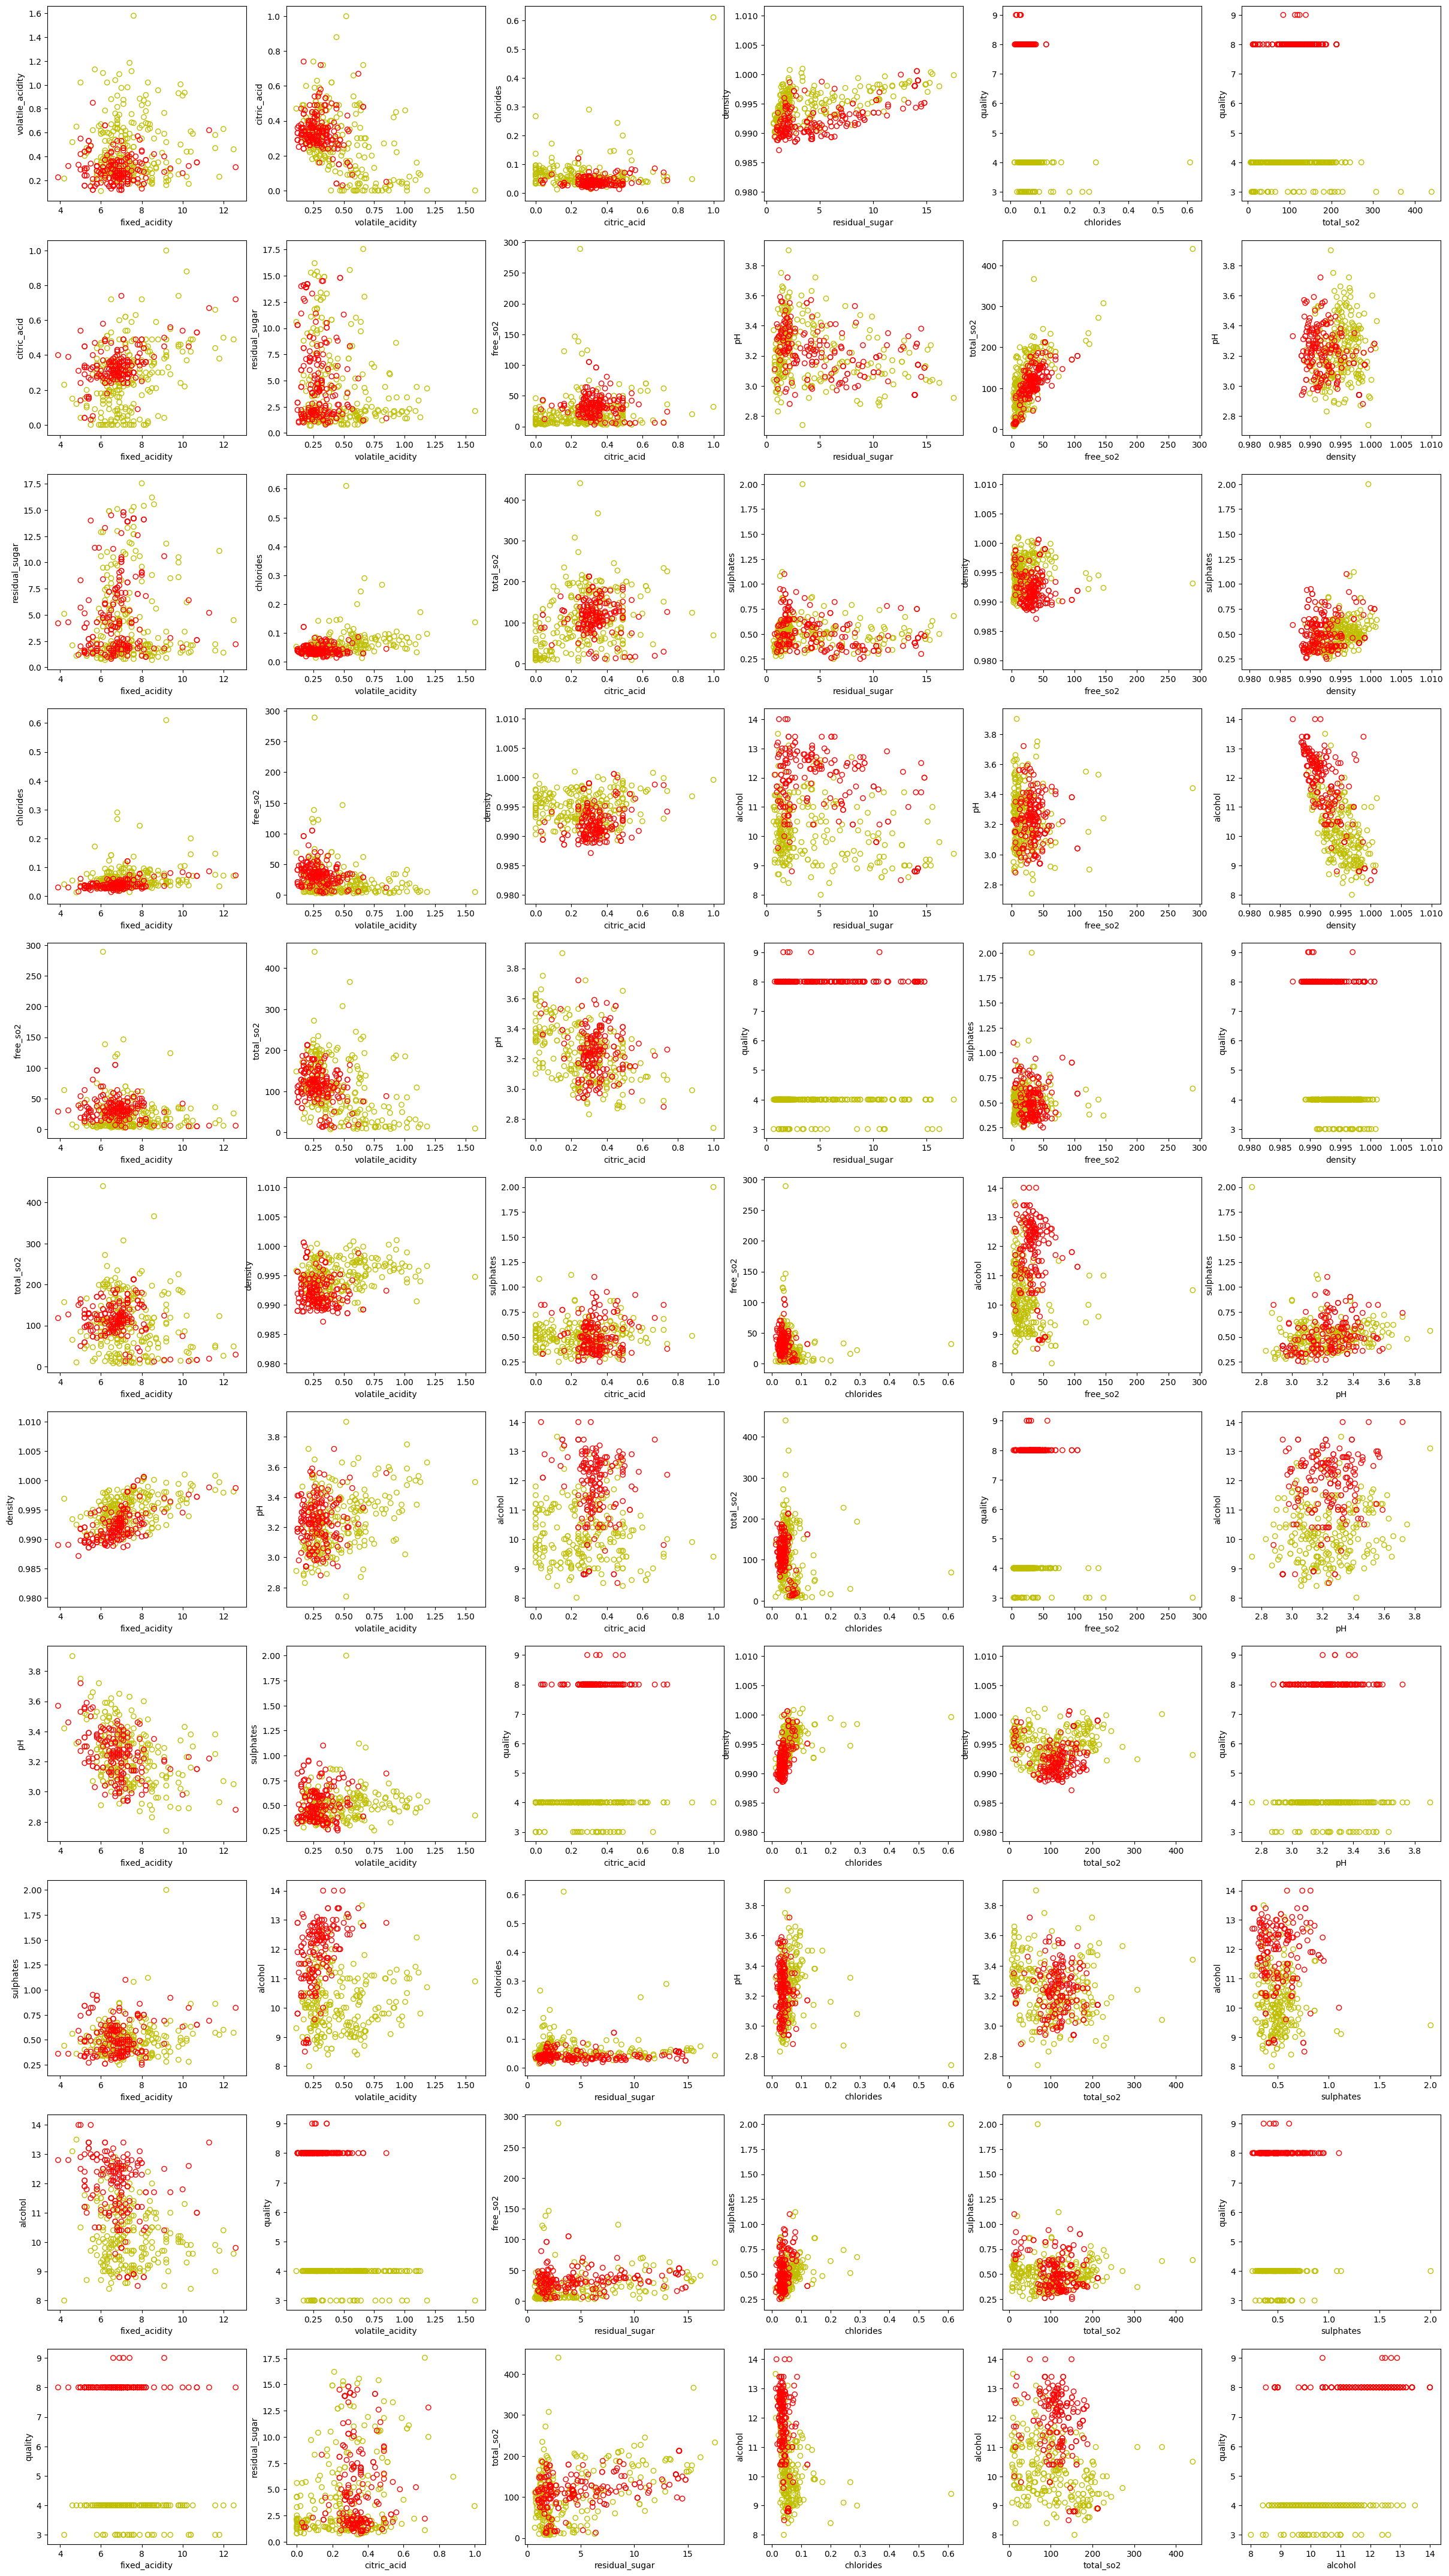

In [11]:
color_dict = Dict("Low Quality" => "y", "High Quality" => "r")

#using for loops to plot all the 66 combinations
fig, axs = subplots(11, 6, figsize=(30, 55))
for i in 1:size(a)[1]
     axs[i].set_xlabel(a[!, 1][i])
     axs[i].set_ylabel(a[!, 2][i])
    for df_c in gb(df, :rating)
        rating = df_c[1, :rating]
        axs[i].scatter(df_c[:, a[!, 1][i]], df_c[:, a[!, 2][i]], marker="o", 
            facecolor="None", edgecolor=color_dict[rating])
    end
end
show()

> The visualization shows us the potential pairs of attributes that are well spaced to be separated by the SVM hyperplane. 

## Preparing the data for input to scikitlearn

To build a predictive model in scikitlearn:
* a matrix `X` that has `n_wines` rows and two columns (one column for each attribute) is constructed.
* a column vector `y` with the labels is construced.

In [34]:
n_wines = nrow(df)
X = zeros(n_wines, 2)
y = zeros(n_wines)
for (i, wine) in enumerate(eachrow(df))
    X[i, 1] = wine[:alcohol]
    X[i, 2] = wine[:pH]
    y[i] = wine[:class]
end

## Loading the data to train the support vector machine (SVM)

> An SVM is trained to classify wines using the data.

> The matrix built is fit in the model.

In [35]:
clf = SVC(kernel="linear", C=1.0)
clf.fit(X, y)

PyObject SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

The accuracy of the trained model is shown.

In [36]:
clf.score(X, y)

0.7815315315315315

> The attributes `alcohol` and `pH` gives the highest score of 78.15%. 

## The SVM Decision Boundary
> 
> Using `contourf` the SVM decision boundary is plotted on the graph that separates the two classes.

In [90]:
alcohol = 7.0:0.1:15.0
pH = 2.0:0.05:6.0
clf_prediction = zeros(length(alcohol), length(pH))

for i=1:length(alcohol)
    for j=1:length(pH)
        x = [alcohol[i] pH[j]]
        clf_prediction[j, i]=clf.predict(x)[1]
    end
end

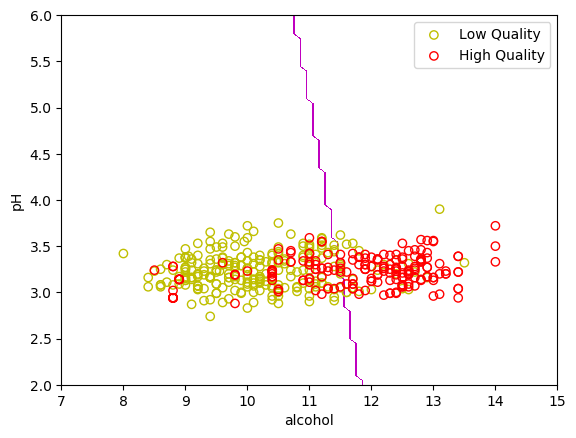

PyObject <matplotlib.legend.Legend object at 0x1a41b23650>

In [93]:
figure()
contourf(alcohol, pH, clf_prediction, [0.0, 0.5, 1.0], colors=["m", "w"])
xlabel("alcohol")
ylabel("pH")
for df_c in gb(df, :rating)
    rating = df_c[1, :rating]
    scatter(df_c[:, :alcohol], df_c[:, :pH], label="$rating", marker="o", 
        facecolor="None", edgecolor=color_dict[rating])
end
legend()

## $K=5$-fold cross validation

>
> The $K=5$-fold cross validation is done for reporting true accuracy of the SVM classifier.
> - The ideal C value is found from a set of 50 C values.
> - The test accuracy is obtained.

In [45]:
K = 5 # number of folds arbitrarily chosen.
kf = KFold(n_wines, n_folds=K)

c_params = 10.0 .^ range(-3, stop=0, length=50)
test_accuracy = zeros(length(c_params))

for (i, c) in enumerate(eachrow(c_params))
    for (train_ids, test_ids) in kf
        clf = SVC(kernel="linear", C=c)
        clf.fit(X[train_ids, :], y[train_ids])
        test_accuracy[i] += clf.score(X[test_ids, :], y[test_ids])
    end
    test_accuracy[i] /= K
end

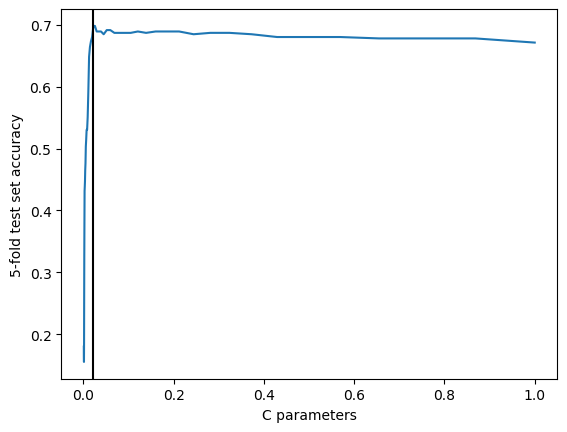

optimal C = 0.022229964825261943
	accuracy: 0.6982890704800817


PyObject Text(24.000000000000007, 0.5, '5-fold test set accuracy')

In [47]:
figure()
plot(c_params, test_accuracy)
optimal_c = c_params[argmax(test_accuracy)]
best_accuracy = test_accuracy[argmax(test_accuracy)]
println("optimal C = ", optimal_c)
println("\taccuracy: ", best_accuracy)
axvline(c_params[argmax(test_accuracy)], color="k")
xlabel("C parameters")
ylabel("$K-fold test set accuracy")

> Through 5-fold cross-validation we see the true accuracy of the SVM classifier.
> - The ***optimal C parameter*** is 0.022229964825261943 and
> - The ***accuracy***  is 0.6982890704800817 
>
> This model can be used to predict the quality of wine and it will be accurate 69.82%.